In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
gpu = 4
multi_gpus = None #[0, 1, 2]
b = 12
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
train_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
val_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
holdout_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/holdout_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')

In [9]:
X_train, y_train = train_h5['X'], train_h5['y']
X_val, y_val = val_h5['X'], val_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [10]:
# dataset overview
y = np.concatenate([np.array(y_train), np.array(y_val), np.array(y_holdout)])
print("# of patients {}, # of healthy controls {}".format(np.sum(y), len(y)-np.sum(y)))

# of patients 475, # of healthy controls 494


In [11]:
print(len(y_train))
print(len(y_val))
print(len(y_holdout))

697
100
172


In [12]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [13]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [14]:
if zero_one_normalize:
    intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

In [15]:
sample = adni_data_train[400]
img = sample["image"]

In [16]:
img.shape

torch.Size([1, 96, 114, 96])

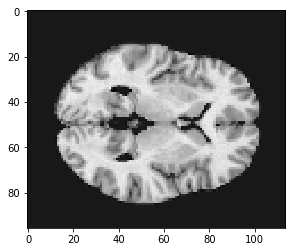

In [17]:
plt.imshow(img[0][:,:,40], cmap='gray')

# Define the classifier

In [18]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_5 = nn.Conv3d(64, 36, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        
        self.classifier_scratch = nn.Sequential(
            nn.Linear(1296, 80),
            nn.Linear(80, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_5(x))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_4(x))
        if print_size:
            print(h.shape)
        
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [19]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [20]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 499845


# Training

In [20]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        
        train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, shuffle=True
        )
        val_loader = DataLoader(
            adni_data_val, batch_size=1, num_workers=1, shuffle=True
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric]))
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies: {}".format(best_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models


In [21]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [22]:
r = 0

In [23]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/full_set/baseline/"
callbacks = [EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

Starting trial 0
torch.Size([1, 96, 114, 96])
59


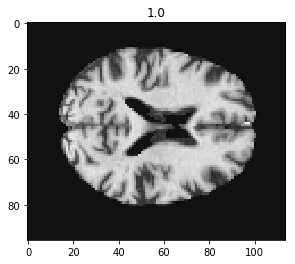

[0,    20] loss: 0.69535
[0,    40] loss: 0.69795
Time elapsed: 0h:0m:24s
train accuracy_score: 53.08 %
train balanced_accuracy: 52.66 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.731942
[1,    20] loss: 0.69688
[1,    40] loss: 0.70249
Time elapsed: 0h:0m:44s
train accuracy_score: 51.08 %
train balanced_accuracy: 50.60 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.683941
[2,    20] loss: 0.69643
[2,    40] loss: 0.69323
Time elapsed: 0h:1m:5s
train accuracy_score: 51.22 %
train balanced_accuracy: 50.93 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.701528
[3,    20] loss: 0.69594
[3,    40] loss: 0.69232
Time elapsed: 0h:1m:25s
train accuracy_score: 52.22 %
train balanced_accuracy: 51.65 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.714916
[4,    20] loss: 0.70311
[4,    40] loss: 0.69343
Time elapsed: 0h:1m:46s
train accuracy_score: 52.94 %
train balanced_accuracy: 52.15 %
val 

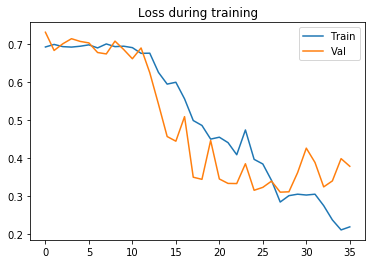

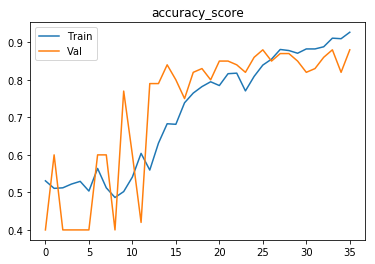

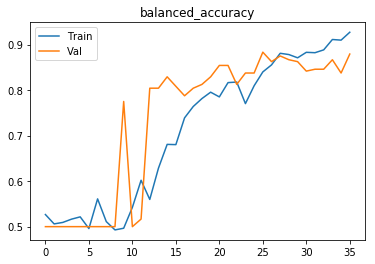

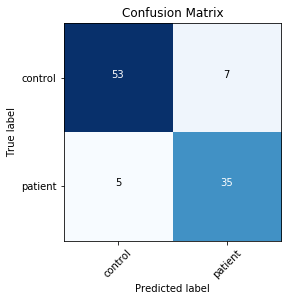

Starting trial 1
torch.Size([1, 96, 114, 96])
59


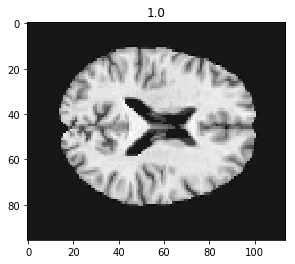

[0,    20] loss: 0.69313
[0,    40] loss: 0.70026
Time elapsed: 0h:0m:18s
train accuracy_score: 49.35 %
train balanced_accuracy: 48.65 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.694405
[1,    20] loss: 0.69077
[1,    40] loss: 0.69045
Time elapsed: 0h:0m:44s
train accuracy_score: 53.80 %
train balanced_accuracy: 53.80 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.706300
[2,    20] loss: 0.69817
[2,    40] loss: 0.68728
Time elapsed: 0h:1m:5s
train accuracy_score: 52.08 %
train balanced_accuracy: 51.07 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.684392
[3,    20] loss: 0.69839
[3,    40] loss: 0.69422
Time elapsed: 0h:1m:26s
train accuracy_score: 48.49 %
train balanced_accuracy: 48.34 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.695315
[4,    20] loss: 0.69514
[4,    40] loss: 0.69329
Time elapsed: 0h:1m:49s
train accuracy_score: 50.07 %
train balanced_accuracy: 49.63 %
val 

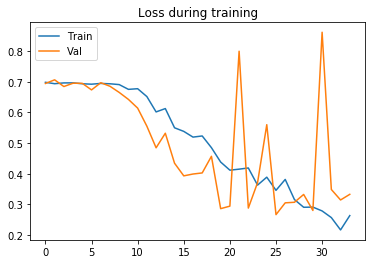

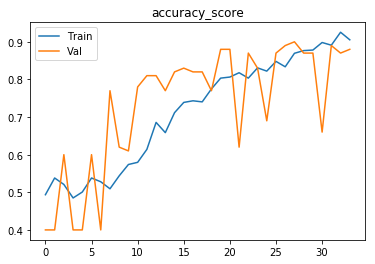

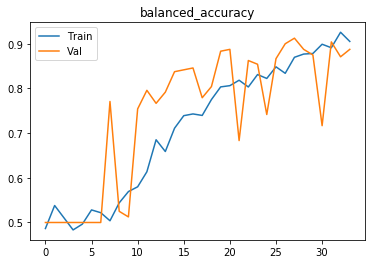

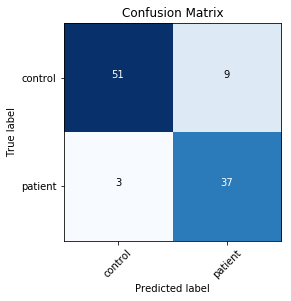

Starting trial 2
torch.Size([1, 96, 114, 96])
59


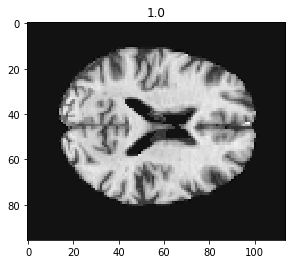

[0,    20] loss: 0.69801
[0,    40] loss: 0.69875
Time elapsed: 0h:0m:18s
train accuracy_score: 53.23 %
train balanced_accuracy: 52.92 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.700457
[1,    20] loss: 0.69553
[1,    40] loss: 0.69973
Time elapsed: 0h:0m:39s
train accuracy_score: 49.21 %
train balanced_accuracy: 48.44 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.716189
[2,    20] loss: 0.70630
[2,    40] loss: 0.69542
Time elapsed: 0h:1m:0s
train accuracy_score: 48.64 %
train balanced_accuracy: 47.52 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.708756
[3,    20] loss: 0.70080
[3,    40] loss: 0.69313
Time elapsed: 0h:1m:21s
train accuracy_score: 50.79 %
train balanced_accuracy: 50.36 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.699098
[4,    20] loss: 0.69208
[4,    40] loss: 0.69737
Time elapsed: 0h:1m:43s
train accuracy_score: 49.64 %
train balanced_accuracy: 48.48 %
val 

[38,    20] loss: 0.20783
[38,    40] loss: 0.17777
Time elapsed: 0h:13m:23s
train accuracy_score: 92.83 %
train balanced_accuracy: 92.87 %
val accuracy_score: 82.00 %
val balanced_accuracy: 83.33 %
Val loss: 0.428062
[39,    20] loss: 0.25006
[39,    40] loss: 0.22083
Time elapsed: 0h:13m:44s
train accuracy_score: 92.83 %
train balanced_accuracy: 92.81 %
val accuracy_score: 85.00 %
val balanced_accuracy: 82.92 %
Val loss: 0.367703
[40,    20] loss: 0.27985
[40,    40] loss: 0.31667
Time elapsed: 0h:14m:4s
train accuracy_score: 89.81 %
train balanced_accuracy: 89.81 %
val accuracy_score: 83.00 %
val balanced_accuracy: 84.58 %
Val loss: 0.452455
[41,    20] loss: 0.24091
[41,    40] loss: 0.14805
Time elapsed: 0h:14m:25s
train accuracy_score: 92.11 %
train balanced_accuracy: 92.14 %
val accuracy_score: 82.00 %
val balanced_accuracy: 83.33 %
Val loss: 0.473526
[42,    20] loss: 0.16154
[42,    40] loss: 0.15500
Time elapsed: 0h:14m:45s
train accuracy_score: 94.84 %
train balanced_accurac

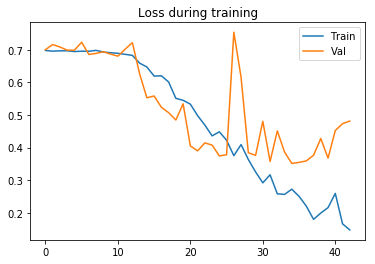

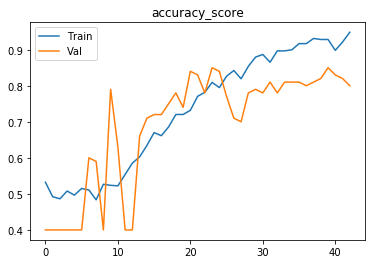

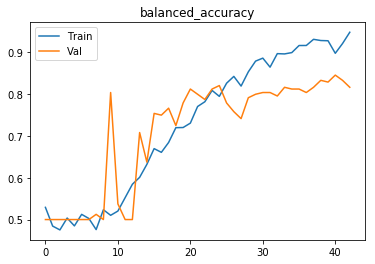

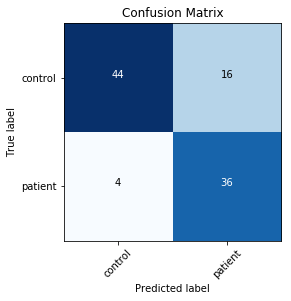

Starting trial 3
torch.Size([1, 96, 114, 96])
59


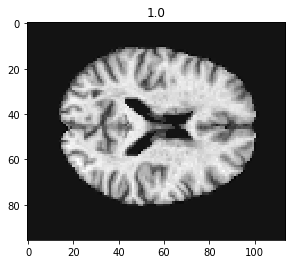

[0,    20] loss: 0.69546
[0,    40] loss: 0.69999
Time elapsed: 0h:0m:20s
train accuracy_score: 49.64 %
train balanced_accuracy: 49.21 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.686563
[1,    20] loss: 0.69759
[1,    40] loss: 0.69407
Time elapsed: 0h:0m:41s
train accuracy_score: 49.64 %
train balanced_accuracy: 49.18 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.677795
[2,    20] loss: 0.69826
[2,    40] loss: 0.70026
Time elapsed: 0h:1m:1s
train accuracy_score: 49.21 %
train balanced_accuracy: 48.80 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.704683
[3,    20] loss: 0.69510
[3,    40] loss: 0.69688
Time elapsed: 0h:1m:21s
train accuracy_score: 49.64 %
train balanced_accuracy: 49.55 %
val accuracy_score: 47.00 %
val balanced_accuracy: 55.83 %
Val loss: 0.692666
[4,    20] loss: 0.69236
[4,    40] loss: 0.69669
Time elapsed: 0h:1m:42s
train accuracy_score: 51.36 %
train balanced_accuracy: 50.68 %
val 

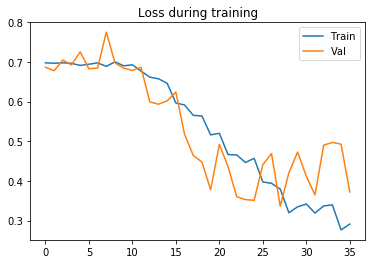

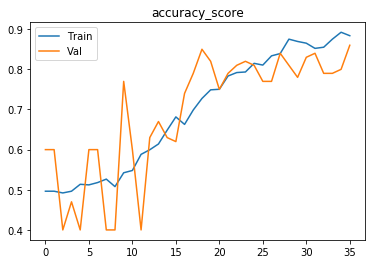

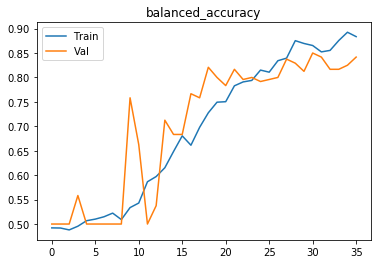

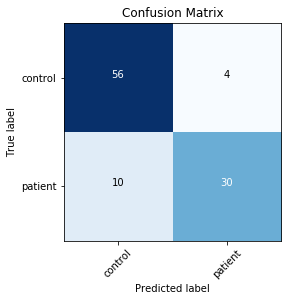

Starting trial 4
torch.Size([1, 96, 114, 96])
59


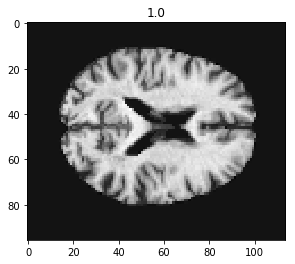

[0,    20] loss: 0.69271
[0,    40] loss: 0.69929
Time elapsed: 0h:0m:18s
train accuracy_score: 52.51 %
train balanced_accuracy: 52.27 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.684850
[1,    20] loss: 0.69919
[1,    40] loss: 0.69292
Time elapsed: 0h:0m:39s
train accuracy_score: 50.93 %
train balanced_accuracy: 50.87 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.687175
[2,    20] loss: 0.69593
[2,    40] loss: 0.69059
Time elapsed: 0h:0m:59s
train accuracy_score: 50.65 %
train balanced_accuracy: 50.29 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.672366
[3,    20] loss: 0.72091
[3,    40] loss: 0.69569
Time elapsed: 0h:1m:20s
train accuracy_score: 46.92 %
train balanced_accuracy: 47.37 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.697847
[4,    20] loss: 0.69457
[4,    40] loss: 0.69398
Time elapsed: 0h:1m:40s
train accuracy_score: 51.08 %
train balanced_accuracy: 50.14 %
val

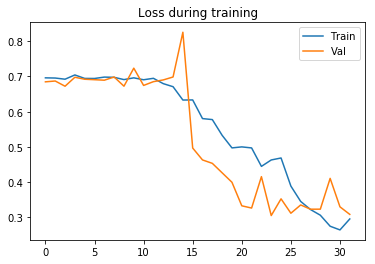

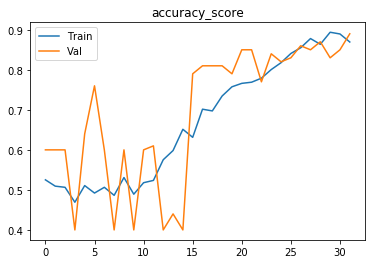

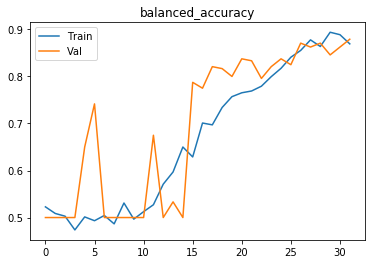

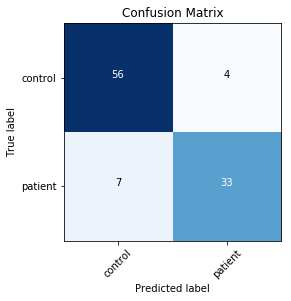

Starting trial 5
torch.Size([1, 96, 114, 96])
59


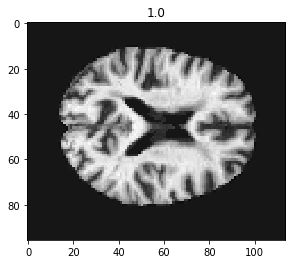

[0,    20] loss: 0.69292
[0,    40] loss: 0.69680
Time elapsed: 0h:0m:18s
train accuracy_score: 50.50 %
train balanced_accuracy: 50.10 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.703857
[1,    20] loss: 0.69308
[1,    40] loss: 0.69115
Time elapsed: 0h:0m:39s
train accuracy_score: 49.93 %
train balanced_accuracy: 49.90 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.685488
[2,    20] loss: 0.70149
[2,    40] loss: 0.69063
Time elapsed: 0h:0m:59s
train accuracy_score: 49.93 %
train balanced_accuracy: 48.83 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.680735
[3,    20] loss: 0.70239
[3,    40] loss: 0.69665
Time elapsed: 0h:1m:20s
train accuracy_score: 51.94 %
train balanced_accuracy: 51.67 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.700282
[4,    20] loss: 0.70122
[4,    40] loss: 0.69778
Time elapsed: 0h:1m:40s
train accuracy_score: 50.22 %
train balanced_accuracy: 49.33 %
val

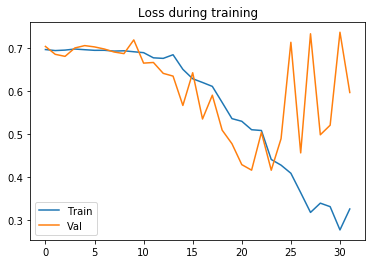

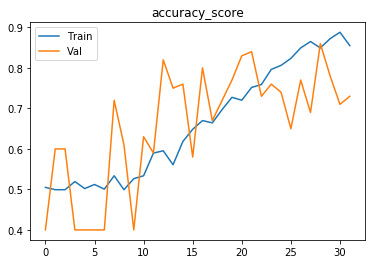

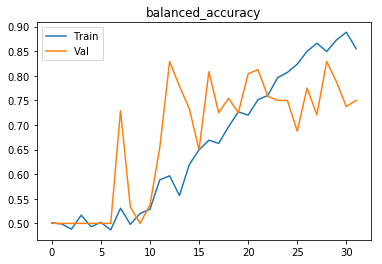

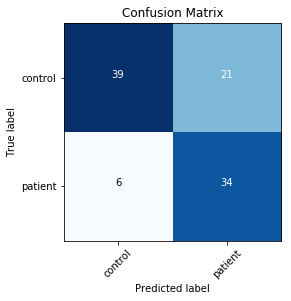

Starting trial 6
torch.Size([1, 96, 114, 96])
59


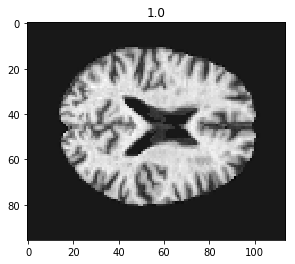

[0,    20] loss: 0.69345
[0,    40] loss: 0.69271
Time elapsed: 0h:0m:18s
train accuracy_score: 50.79 %
train balanced_accuracy: 50.60 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.729946
[1,    20] loss: 0.69769
[1,    40] loss: 0.70073
Time elapsed: 0h:0m:38s
train accuracy_score: 48.21 %
train balanced_accuracy: 47.53 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.707242
[2,    20] loss: 0.69216
[2,    40] loss: 0.69454
Time elapsed: 0h:0m:59s
train accuracy_score: 51.51 %
train balanced_accuracy: 50.55 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.695186
[3,    20] loss: 0.69580
[3,    40] loss: 0.68494
Time elapsed: 0h:1m:19s
train accuracy_score: 55.52 %
train balanced_accuracy: 54.71 %
val accuracy_score: 52.00 %
val balanced_accuracy: 45.83 %
Val loss: 0.692253
[4,    20] loss: 0.70354
[4,    40] loss: 0.69469
Time elapsed: 0h:1m:39s
train accuracy_score: 50.36 %
train balanced_accuracy: 49.62 %
val

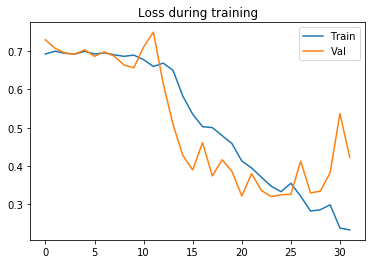

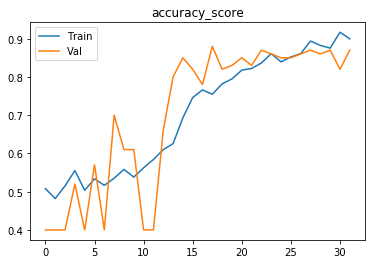

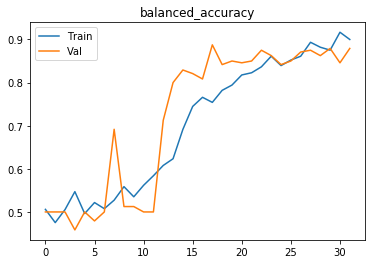

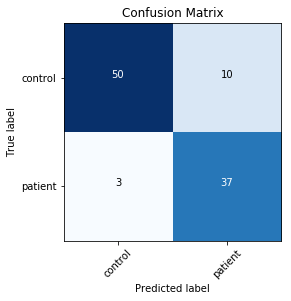

Starting trial 7
torch.Size([1, 96, 114, 96])
59


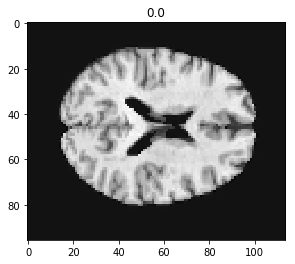

[0,    20] loss: 0.69845
[0,    40] loss: 0.69457
Time elapsed: 0h:0m:18s
train accuracy_score: 49.35 %
train balanced_accuracy: 49.28 %
val accuracy_score: 42.00 %
val balanced_accuracy: 51.67 %
Val loss: 0.693316
[1,    20] loss: 0.69602
[1,    40] loss: 0.69480
Time elapsed: 0h:0m:39s
train accuracy_score: 49.64 %
train balanced_accuracy: 49.87 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.689641
[2,    20] loss: 0.69132
[2,    40] loss: 0.69516
Time elapsed: 0h:1m:0s
train accuracy_score: 50.65 %
train balanced_accuracy: 50.88 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.697009
[3,    20] loss: 0.69233
[3,    40] loss: 0.69216
Time elapsed: 0h:1m:20s
train accuracy_score: 53.37 %
train balanced_accuracy: 52.98 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.665184
[4,    20] loss: 0.69211
[4,    40] loss: 0.70381
Time elapsed: 0h:1m:41s
train accuracy_score: 55.95 %
train balanced_accuracy: 55.81 %
val 

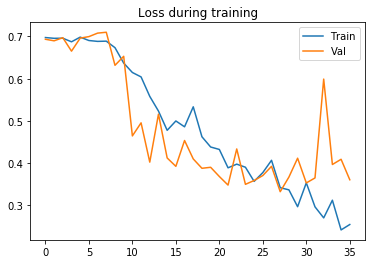

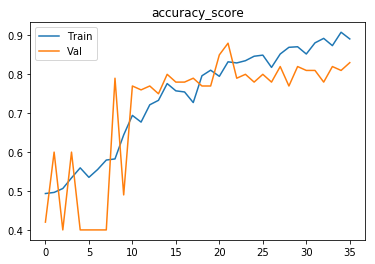

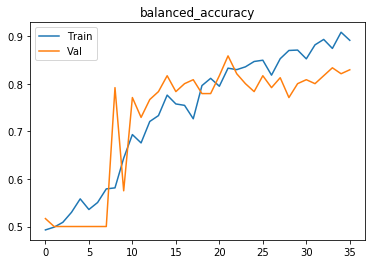

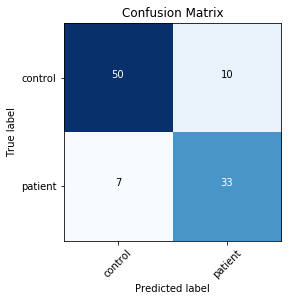

Starting trial 8
torch.Size([1, 96, 114, 96])
59


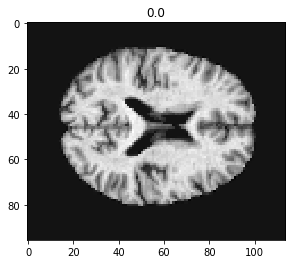

[0,    20] loss: 0.68828
[0,    40] loss: 0.69785
Time elapsed: 0h:0m:18s
train accuracy_score: 52.51 %
train balanced_accuracy: 51.71 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.704335
[1,    20] loss: 0.69601
[1,    40] loss: 0.69994
Time elapsed: 0h:0m:39s
train accuracy_score: 47.92 %
train balanced_accuracy: 47.70 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.695095
[2,    20] loss: 0.70242
[2,    40] loss: 0.69353
Time elapsed: 0h:1m:0s
train accuracy_score: 51.08 %
train balanced_accuracy: 49.85 %
val accuracy_score: 73.00 %
val balanced_accuracy: 75.42 %
Val loss: 0.692314
[3,    20] loss: 0.69520
[3,    40] loss: 0.68812
Time elapsed: 0h:1m:21s
train accuracy_score: 51.65 %
train balanced_accuracy: 51.49 %
val accuracy_score: 71.00 %
val balanced_accuracy: 74.58 %
Val loss: 0.692091
[4,    20] loss: 0.68983
[4,    40] loss: 0.69380
Time elapsed: 0h:1m:41s
train accuracy_score: 51.51 %
train balanced_accuracy: 51.96 %
val 

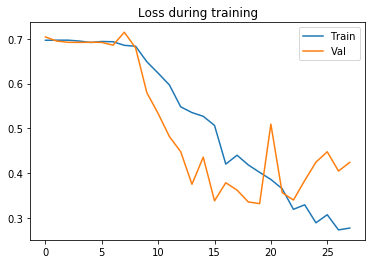

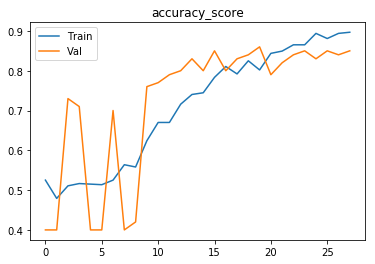

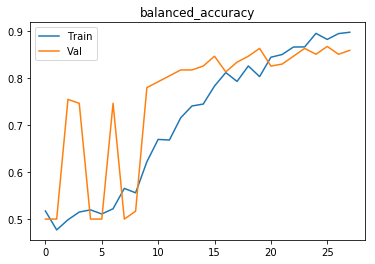

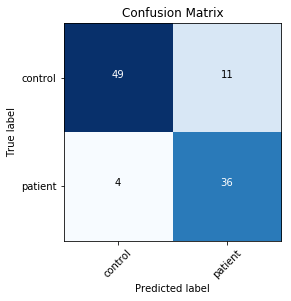

Starting trial 9
torch.Size([1, 96, 114, 96])
59


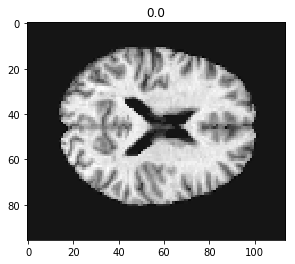

[0,    20] loss: 0.69652
[0,    40] loss: 0.69470
Time elapsed: 0h:0m:18s
train accuracy_score: 49.64 %
train balanced_accuracy: 48.39 %
val accuracy_score: 49.00 %
val balanced_accuracy: 47.50 %
Val loss: 0.693551
[1,    20] loss: 0.69955
[1,    40] loss: 0.69014
Time elapsed: 0h:0m:38s
train accuracy_score: 50.50 %
train balanced_accuracy: 50.03 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.709709
[2,    20] loss: 0.69435
[2,    40] loss: 0.69580
Time elapsed: 0h:0m:59s
train accuracy_score: 51.22 %
train balanced_accuracy: 50.77 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.706114
[3,    20] loss: 0.69779
[3,    40] loss: 0.69494
Time elapsed: 0h:1m:19s
train accuracy_score: 51.36 %
train balanced_accuracy: 50.77 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
Val loss: 0.729100
[4,    20] loss: 0.69991
[4,    40] loss: 0.69752
Time elapsed: 0h:1m:39s
train accuracy_score: 52.08 %
train balanced_accuracy: 51.00 %
val

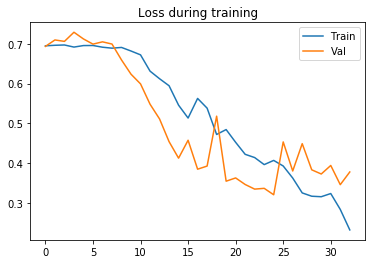

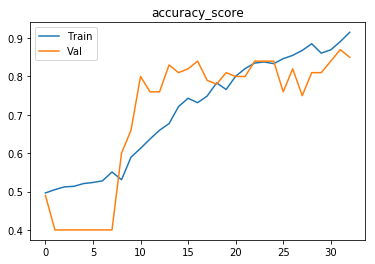

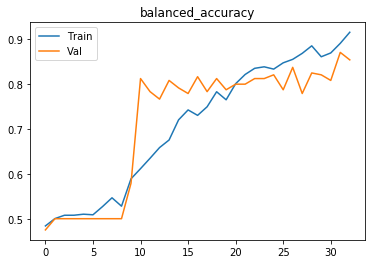

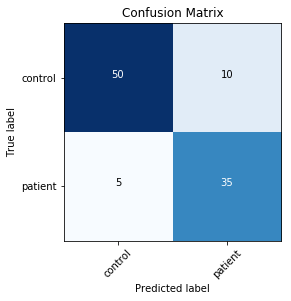

################################
################################
All accuracies: [0.8791666666666668, 0.8875, 0.8166666666666668, 0.8416666666666667, 0.8791666666666668, 0.75, 0.8791666666666668, 0.8291666666666666, 0.8583333333333334, 0.8541666666666667]
Best accuracies: [0.8833333333333333, 0.9125, 0.8458333333333334, 0.85, 0.8791666666666668, 0.8291666666666666, 0.8875, 0.8583333333333334, 0.8666666666666667, 0.8708333333333332]
Best accuracies mean: 0.8683333333333334 All :[0.8833333333333333, 0.9125, 0.8458333333333334, 0.85, 0.8791666666666668, 0.8291666666666666, 0.8875, 0.8583333333333334, 0.8666666666666667, 0.8708333333333332]
0.8474999999999999
0.03949331870357597


In [24]:
fold_metric, models = run(net=net, data=adni_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [26]:
5/0

ZeroDivisionError: division by zero

# Start inference

### Using best model checkpoint for inference

In [24]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [25]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [28]:
!ls $model_dir

/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/full_set/baseline/repeat_0_cv_fold_0_BEST_ITERATION.h5


In [26]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Fold 0


UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [28]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))

Fold 0
0.8684536082474227
Fold 1
0.8387628865979382
Fold 2
0.8569072164948454
Fold 3
0.8569072164948454
Fold 4
0.8490721649484536
Fold 5
0.7178694158075601
Fold 6
0.8602749140893471
Fold 7
0.8066666666666666
Fold 8
0.843573883161512
Fold 9
0.861786941580756
######## Final results ########
          0
0  0.868454
1  0.838763
2  0.856907
3  0.856907
4  0.849072
5  0.717869
6  0.860275
7  0.806667
8  0.843574
9  0.861787
Balanced accuracy mean 83.60 %
